In [1]:
#Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# importing prepared dataset

data = pd.read_csv('../data/exercise_df_pre_modelling.csv')

## Encoding 

Before I can start plugging my data into some models there are a few more things I need to take care of. First we are going to encode the categorical columns.

In [3]:
# encoding categorical columns and saving mapping model 

columns_to_encode = ['exercise', 'watch_location', 'crown_orientation']

label_mappings = {}
enc = LabelEncoder()

for column in columns_to_encode:
    enc.fit_transform(data[column])
    
    data[f'{column}'] = enc.transform(data[column])
    label_mappings[column] = dict(zip(enc.classes_, enc.transform(enc.classes_)))

# Display the label mappings
for column, mapping in label_mappings.items():
    print(f"Column: {column}")
    for label, encoded_value in mapping.items():
        print(f"  {label} -> {encoded_value}")
    print()

Column: exercise
  ARM_RAISE-DUMBBELL -> 0
  BICEP_CURL-DUMBBELL -> 1
  BIRD_DOG -> 2
  BURPEE -> 3
  CRUNCHES -> 4
  HAMMER_CURL-DUMBBELL -> 5
  OVERHEAD_PRESS-DUMBBELL -> 6
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-LEFT -> 7
  TRICEP_KICKBACK-BENT_OVER+SINGLE_ARM-DUMBBELL-RIGHT -> 8
  V_UP -> 9

Column: watch_location
  LEFT -> 0
  RIGHT -> 1

Column: crown_orientation
  LEFT -> 0
  RIGHT -> 1



In [4]:
data.head(1)

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1,...,euler_z_117,euler_x_118,euler_y_118,euler_z_118,euler_x_119,euler_y_119,euler_z_119,euler_x_120,euler_y_120,euler_z_120
0,0,1,0,4.818261,0.851037,0.024017,9.201472,2.970833,-0.085816,-1.236302,...,0.068083,0.316288,-0.37655,0.04075,0.278083,-0.85458,0.019844,0.186179,-1.131981,0.086393


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1768 entries, 0 to 1767
Columns: 368 entries, exercise to euler_z_120
dtypes: float64(365), int32(3)
memory usage: 4.9 MB


We can see now that all of our data are int or float.

In [6]:
data.iloc[:,:20].describe()

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1,euler_z_1,euler_x_2,euler_y_2,euler_z_2,euler_x_3,euler_y_3,euler_z_3,euler_x_4,euler_y_4,euler_z_4
count,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000
mean,4.161765,0.498869,0.500566,3.075143,1.140106,0.159040,-0.552157,2.844651,0.005314,-0.004561,-0.013287,0.005116,-0.005539,-0.003244,0.021730,-0.010772,0.020410,0.023884,-0.010729,0.032418
std,2.856672,0.500140,0.500141,1.810480,0.388024,0.120412,18.833785,2.364977,1.824003,0.772781,1.678963,1.787894,0.734351,1.700784,1.710783,0.670936,1.731052,1.598623,0.691482,1.736577
min,0.000000,0.000000,0.000000,0.000068,0.500301,0.000028,-44.753317,0.773077,-3.134623,-1.529143,-3.138694,-3.141491,-1.506369,-3.119051,-3.141076,-1.542554,-3.125885,-3.139041,-1.541828,-3.140974
25%,2.000000,0.000000,0.000000,1.516402,0.846894,0.060804,-14.723011,1.522045,-1.437962,-0.609998,-1.597836,-1.341938,-0.578529,-1.623846,-1.320015,-0.515320,-1.566908,-1.250440,-0.520233,-1.593738
50%,4.000000,0.000000,1.000000,3.051973,1.103707,0.134453,-0.955696,2.094097,0.037029,-0.033025,0.023405,-0.010286,-0.029389,0.051814,0.042219,-0.020756,0.039621,0.014764,-0.016577,0.036437
75%,6.000000,1.000000,1.000000,4.603642,1.391872,0.226439,13.541870,3.087500,1.412526,0.627743,1.540600,1.332046,0.592276,1.510852,1.321814,0.495848,1.525983,1.254650,0.503572,1.598302
max,9.000000,1.000000,1.000000,6.278917,2.861832,0.777604,44.344465,16.791667,3.139900,1.521754,3.140739,3.140135,1.536095,3.137109,3.139074,1.497512,3.139442,3.138381,1.533896,3.141549


While scaling is necessary for many models, it is not necessary for all. I will be trying a RandomForest model first which does not require scaling, however it is recommended for some of the other models I'm considering so I will scale it.

## Scaling

In [13]:
# Scaling data

columns_to_scale = data.columns[3:]
scaler = StandardScaler()

scaled_data = scaler.fit_transform(data[columns_to_scale])
scaled_df = pd.concat([data.iloc[:, :3], pd.DataFrame(scaled_data, columns=columns_to_scale)], axis=1)

In [14]:
# setting to format how the floats display

pd.set_option('display.float_format', '{:.6f}'.format)

In [15]:
scaled_df.iloc[:,:10].describe()

,exercise,watch_location,crown_orientation,ref_xy_rotation,rel_baseline_speed,max_rel_speed_change,wrist_offset_deg,avg_rep_time,euler_x_1,euler_y_1
count,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000,1768.000000
mean,4.161765,0.498869,0.500566,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000
std,2.856672,0.500140,0.500141,1.000283,1.000283,1.000283,1.000283,1.000283,1.000283,1.000283
min,0.000000,0.000000,0.000000,-1.698967,-1.649346,-1.320944,-2.347572,-0.876186,-1.721940,-1.973409
25%,2.000000,0.000000,0.000000,-0.861198,-0.755867,-0.816069,-0.752630,-0.559405,-0.791492,-0.783673
50%,4.000000,0.000000,1.000000,-0.012801,-0.093831,-0.204252,-0.021432,-0.317452,0.017393,-0.036843
75%,6.000000,1.000000,1.000000,0.844489,0.649026,0.559893,0.748549,0.102715,0.771715,0.818450
max,9.000000,1.000000,1.000000,1.770072,4.438419,5.138530,2.384509,5.898985,1.719006,1.975652


## Splitting

On my first run through of my work I had initially split my data using a stratified method to ensure I got an even distribution of the exercises. However, my curiosity getting the better of me requires that I also try a set just split by percentage.

In [16]:
# splitting
X_scale=scaled_df.drop(['exercise'], axis=1)
y_scale=scaled_df['exercise']

In [17]:
print(X_scale.shape, y_scale.shape)

(1768, 367) (1768,)


#### Unscaled

Again to satisfy my curiosity I ran some of the models on unscaled data too, just so I could see the difference. Not surprisingly it did not do as well.

In [20]:
X_norm=data.drop(['exercise'], axis=1)
y_norm=data['exercise']

In [21]:
print(X_norm.shape, y_norm.shape)

(1768, 367) (1768,)


#### Stratified on data

Using a stratified splitter to make sure each exercise is represented as evenly as possible.

In [22]:
#Stratified on Scaled

# Create a StratifiedShuffleSplit object
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Use the splitter to get indices for the train and test sets
for train_index, test_index in stratified_splitter.split(X_scale, y_scale):
    X_train_strat_s, X_test_strat_s = X_scale.iloc[train_index], X_scale.iloc[test_index]
    y_train_strat_s, y_test_strat_s = y_scale.iloc[train_index], y_scale.iloc[test_index]

In [23]:
print(y_train_strat_s.value_counts())
print(y_test_strat_s.value_counts())

print(y_train_strat_s.value_counts().sum())
print(y_test_strat_s.value_counts().sum())

exercise
3    160
1    160
2    160
0    160
5    160
9    160
6    157
4    139
8     80
7     78
Name: count, dtype: int64
exercise
0    40
2    40
1    40
5    40
9    40
3    40
6    39
4    35
7    20
8    20
Name: count, dtype: int64
1414
354


In [24]:
#Stratified on Unscaled

stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Use the splitter to get indices for the train and test sets
for train_index, test_index in stratified_splitter.split(X_norm, y_norm):
    X_train_strat_n, X_test_strat_n = X_norm.iloc[train_index], X_norm.iloc[test_index]
    y_train_strat_n, y_test_strat_n = y_norm.iloc[train_index], y_norm.iloc[test_index]

#### Unstratified on data

In [25]:
# Unstratified split using train_test_split on scaled

X_train_un_s, X_test_un_s, y_train_un_s, y_test_un_s = train_test_split(X_scale, y_scale, test_size = 0.3, random_state = 3)

In [26]:
print(y_train_un_s.value_counts())
print(y_test_un_s.value_counts())

print(y_train_un_s.value_counts().sum())
print(y_test_un_s.value_counts().sum())

exercise
2    150
9    147
3    147
6    145
1    135
0    135
5    126
4    120
8     72
7     60
Name: count, dtype: int64
exercise
5    74
0    65
1    65
4    54
9    53
3    53
6    51
2    50
7    38
8    28
Name: count, dtype: int64
1237
531


In [27]:
# Unstratified split using train_test_split on unscaled

X_train_un_n, X_test_un_n, y_train_un_n, y_test_un_n = train_test_split(X_norm, y_norm, test_size = 0.3, random_state = 3)

Below is a plot to see the breakdown of the target data with the different splitting methods. 

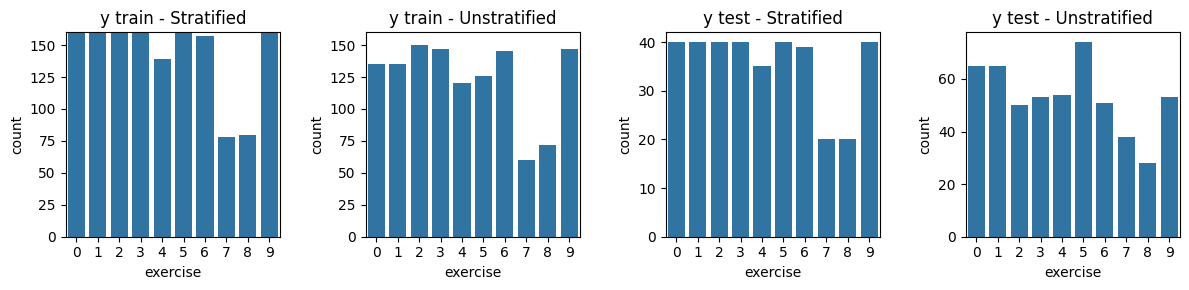

In [28]:
# Visualizing the differences in splitting methods

max_count_test = max(y_train_strat_s.value_counts().max(), y_test_un_s.value_counts().max())

plt.figure(figsize=(12, 3))

plt.subplot(1, 4, 1)
sns.countplot(x=y_train_strat_s)
plt.ylim(0, max_count_test)  
plt.title('y train - Stratified')

plt.subplot(1, 4, 2)
sns.countplot(x=y_train_un_s)
plt.ylim(0, max_count_test) 
plt.title('y train - Unstratified')

plt.subplot(1, 4, 3)
sns.countplot(x=y_test_strat_s)
plt.title('y test - Stratified')

plt.subplot(1, 4, 4)
sns.countplot(x=y_test_un_s)
plt.title('y test - Unstratified')

plt.tight_layout()
plt.subplots_adjust(wspace=0.4)  
plt.show()


# Modelling

## RandomForest

In [29]:
# setting up basic model

rfc = RandomForestClassifier(random_state = 3)

#### Stratified/Scaled

In [31]:
# fitting the model to the stratified/scaled data

rfc.fit(X_train_strat_s, y_train_strat_s)

RandomForestClassifier(random_state=3)

In [32]:
# running the predictions on training and testing data

y_train_pred_strat_s = rfc.predict(X_train_strat_s)
y_test_pred_strat_s = rfc.predict(X_test_strat_s)

In [35]:
# accuracy results for basic RandomForestClassifier

print('Training accuracy (Scaled/Stratified) :',accuracy_score(y_train_strat_s, y_train_pred_strat_s))
print('Testing accuracy  (Scaled/Stratified) :' ,accuracy_score(y_test_strat_s, y_test_pred_strat_s))

Training accuracy (Scaled/Stratified) : 1.0
Testing accuracy  (Scaled/Stratified) : 0.9011299435028248


In [36]:
# Classification Report

print(classification_report(y_test_strat_s, y_test_pred_strat_s))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.84      0.90      0.87        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.82      0.77      0.79        35
           5       0.83      0.85      0.84        40
           6       0.79      0.95      0.86        39
           7       0.89      0.85      0.87        20
           8       0.87      0.65      0.74        20
           9       0.97      0.97      0.97        40

    accuracy                           0.90       354
   macro avg       0.90      0.88      0.89       354
weighted avg       0.90      0.90      0.90       354



In [37]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_strat_s, y_test_pred_strat_s)
conf_matrix

array([[36,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0, 27,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 34,  5,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  2, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1, 17,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  4,  2, 13,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 39]], dtype=int64)

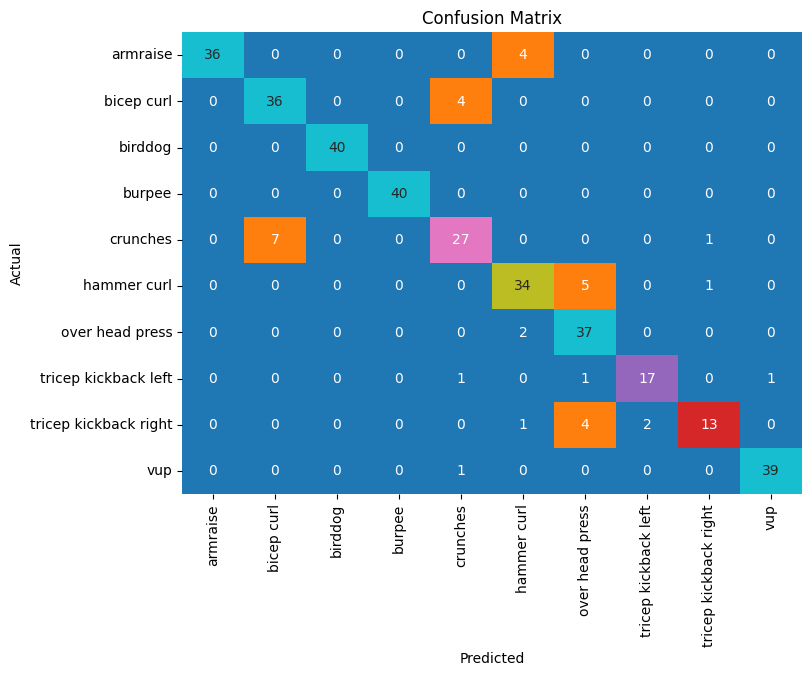

In [40]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Misclassification per exercise:

0) armraise - 4 > these 4 were predicted to be hammer curls
1) bicep curl - 4 > these 4 were predicted to be crunches
2) birddog - 0
3) burpee - 0
4) crunches - 8 > 7/8 were predicted to be bicep curls
5) hammer curl - 6 > 5/6 were predicted to be over head presses
6) over head press - 2
7) tricep kickback left - 3
8) tricep kickback right - 7 > 4/7 were predicted to be over head presses
9) vup - 1

The model below was performed on the data split without stratification. As you can see below, the stratified method did better, so I will stick with that one. 

#### Unstratified/Scaled

In [41]:
# fitting model to unstratified dataset

rfc.fit(X_train_un_s, y_train_un_s)

RandomForestClassifier(random_state=3)

In [42]:
# running the predictions on training and testing data

y_train_pred_un_s = rfc.predict(X_train_un_s)
y_test_pred_un_s = rfc.predict(X_test_un_s)

In [43]:
# Accuracy results for this model

print('Train accuracy:',accuracy_score(y_train_un_s, y_train_pred_un_s))
print('Test accuracy:',accuracy_score(y_test_un_s, y_test_pred_un_s))

Train accuracy: 1.0
Test accuracy: 0.8813559322033898


In [49]:
# Classification Report

print(classification_report(y_test_un_s, y_test_pred_un_s))


              precision    recall  f1-score   support

           0       0.91      0.94      0.92        65
           1       0.89      0.91      0.90        65
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        53
           4       0.83      0.83      0.83        54
           5       0.83      0.73      0.78        74
           6       0.70      0.96      0.81        51
           7       0.89      0.63      0.74        38
           8       0.80      0.71      0.75        28
           9       0.98      1.00      0.99        53

    accuracy                           0.88       531
   macro avg       0.88      0.87      0.87       531
weighted avg       0.89      0.88      0.88       531



In [48]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_un_s, y_test_pred_un_s)
conf_matrix

array([[61,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 59,  0,  0,  6,  0,  0,  0,  0,  0],
       [ 0,  0, 50,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 53,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0, 45,  1,  0,  0,  0,  1],
       [ 6,  0,  0,  0,  0, 54, 12,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  2, 49,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  4,  5, 24,  3,  0],
       [ 0,  0,  0,  0,  1,  0,  4,  3, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 53]], dtype=int64)

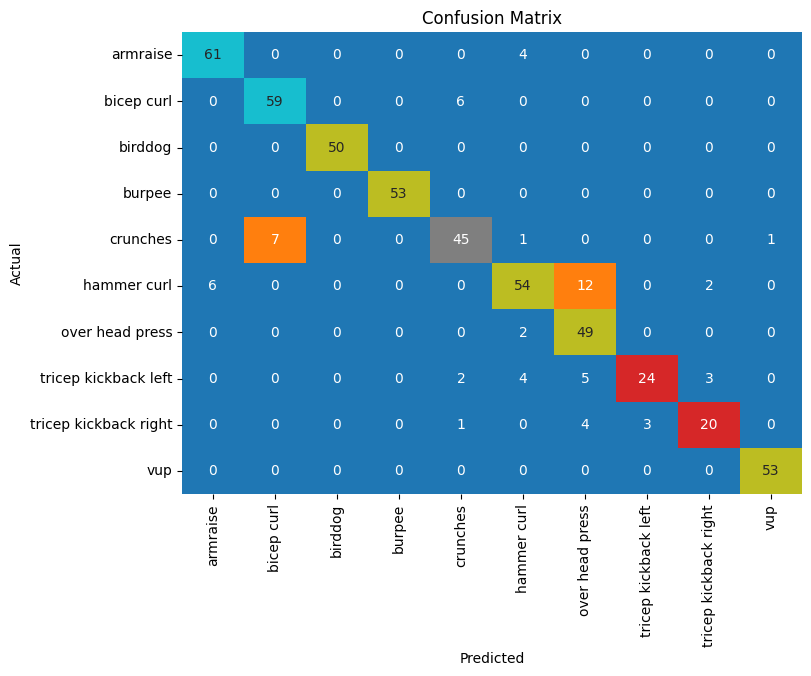

In [47]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Misclassification per exercise: The first number is from the confusion matrix with the stratified data. Looks like that did a better job over all.

0) armraise - 4 - 4
1) bicep curl - 4 - 6
2) birddog - 0 - 0
3) burpee - 0 - 0
4) crunches - 8 - 9
5) hammer curl - 6 - 20
6) over head press - 2 - 2
7) tricep kickback left - 3 - 14
8) tricep kickback right - 7 - 8
9) vup - 1 - 0

As the scaling doesn't matter for the RandomForestClassifier I won't be looking at that set.

### Hyperparameter Tuning for RandomForest

I will be using GridSearchCV to assess optimal parameters for my models. Because the stratified split data did better for the base model I will be using that for my hyperparameter tuning.

In [51]:
# Parameter settings

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

This model took some time to run. Just something to keep in mind before executing it.

In [52]:
# Using GridSearchCV

grid_search_rfc = GridSearchCV(rfc, param_grid, cv=5, n_jobs=-1)
grid_search_rfc.fit(X_train_strat_s, y_train_strat_s)

print("Best Hyperparameters:", grid_search_rfc.best_params_)

best_model = grid_search_rfc.best_estimator_


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [53]:
y_pred_best_model_strat_s = best_model.predict(X_test_strat_s)

In [55]:
print('Accuracy score :', accuracy_score(y_test_strat_s, y_pred_best_model_strat_s))

Accuracy score : 0.9011299435028248


In [56]:
# Confusion Matrix

conf_matrix = confusion_matrix(y_test_strat_s, y_pred_best_model_strat_s)
conf_matrix

array([[36,  0,  0,  0,  0,  4,  0,  0,  0,  0],
       [ 0, 36,  0,  0,  4,  0,  0,  0,  0,  0],
       [ 0,  0, 40,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  0,  0, 27,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 34,  5,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  2, 37,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  1, 17,  0,  1],
       [ 0,  0,  0,  0,  0,  1,  4,  2, 13,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0, 39]], dtype=int64)

Seems like the hyperparameter tuning made zero difference with this model. Lets give some other models a try.

## SVM

#### Stratified/Scaled

In [57]:
# Trying a quick SVM run through with stratified/scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_strat_s, y_train_strat_s)

y_pred_svm_train_strat_s = svm_model.predict(X_train_strat_s)
print('Training accuracy:', accuracy_score(y_train_strat_s, y_pred_svm_train_strat_s))

y_pred_svm_test_strat_s = svm_model.predict(X_test_strat_s)
print('Test accuracy:', accuracy_score(y_test_strat_s, y_pred_svm_test_strat_s))

Training accuracy: 0.9123055162659123
Test accuracy: 0.788135593220339


In [58]:
#Classification Report

print(classification_report(y_test_strat_s, y_pred_svm_test_strat_s))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91        40
           1       0.79      0.78      0.78        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.68      0.74      0.71        35
           5       0.50      0.53      0.51        40
           6       0.49      0.64      0.56        39
           7       0.85      0.55      0.67        20
           8       0.77      0.50      0.61        20
           9       1.00      0.97      0.99        40

    accuracy                           0.79       354
   macro avg       0.80      0.76      0.77       354
weighted avg       0.80      0.79      0.79       354



Clearly not as good as the RandomForest model off the bat, but of course we will try some hyperparameter tuning with GridSearchCV to see if we can make it better.

#### Unstratified/Scaled

In [73]:
# Trying a quick SVM run through with unstratified/scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_un_s, y_train_un_s)

y_pred_svm_train_un_s = svm_model.predict(X_train_un_s)
print('Training accuracy:', accuracy_score(y_train_un_s, y_pred_svm_train_un_s))

y_pred_svm_test_un_s = svm_model.predict(X_test_un_s)
print('Test accuracy:', accuracy_score(y_test_un_s, y_pred_svm_test_un_s))

Training accuracy: 0.9078415521422797
Test accuracy: 0.7344632768361582


Again the unstratified data did not do as well, we will not revisit it again after this model.

#### Stratified/Not Scaled

The model runs with the unscaled data is for my personal interest to see how much of a differenct it makes for this data. 

In [59]:
# Trying a quick SVM run through with stratified/not scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_strat_n, y_train_strat_n)

y_pred_svm_train_strat_n = svm_model.predict(X_train_strat_n)
print('Training accuracy:', accuracy_score(y_train_strat_n, y_pred_svm_train_strat_n))

y_pred_svm_test_strat_n = svm_model.predict(X_test_strat_n)
print('Test accuracy:', accuracy_score(y_test_strat_n, y_pred_svm_test_strat_n))

Training accuracy: 0.8804809052333805
Test accuracy: 0.7570621468926554


#### Unstratified/Not Scaled

In [60]:
# Trying a quick SVM run through with unstratified/not scaled data

svm_model = SVC(kernel='rbf', C=1)
svm_model.fit(X_train_un_n, y_train_un_n)

y_pred_svm_train_un_n = svm_model.predict(X_train_un_n)
print('Training accuracy:', accuracy_score(y_train_un_n, y_pred_svm_train_un_n))

y_pred_svm_test_un_n = svm_model.predict(X_test_un_n)
print('Test accuracy:', accuracy_score(y_test_un_n, y_pred_svm_test_un_n))

Training accuracy: 0.8617623282134196
Test accuracy: 0.6892655367231638


The unscaled data was worse all around for the SVM model. Not that that was unexpected result. We will also leave the unscaled data behind at this point.

### SVM Hypertuning with GridSearchCV

In [61]:
# using stratified/scaled data, setting up parameter grid and fitting to data

param_grid = {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'degree': [2, 3, 4, 5],
              'kernel': ['rbf', 'poly']}

grid_svc = GridSearchCV(SVC(), param_grid, cv=5)
grid_svc.fit(X_train_strat_s, y_train_strat_s)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50,
                               100, 500, 1000],
                         'degree': [2, 3, 4, 5],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'poly']})

In [62]:
grid_svc.best_params_

{'C': 100, 'degree': 2, 'gamma': 0.001, 'kernel': 'rbf'}

In [63]:
best_params = {'C': 100, 'gamma': 0.001,'degree': 2, 'kernel': 'rbf'}
best_svc_model = SVC(**best_params)

best_svc_model.fit(X_train_strat_s, y_train_strat_s)
y_pred_svm_best = best_svc_model.predict(X_test_strat_s)

In [64]:
accuracy = accuracy_score(y_test_strat_s, y_pred_svm_best)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8926553672316384


In [65]:
#Classification Report

classification_rep = classification_report(y_test_strat_s, y_pred_svm_best)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        40
           1       0.85      0.72      0.78        40
           2       1.00      1.00      1.00        40
           3       1.00      1.00      1.00        40
           4       0.71      0.77      0.74        35
           5       0.82      0.80      0.81        40
           6       0.94      0.85      0.89        39
           7       0.87      1.00      0.93        20
           8       0.76      0.95      0.84        20
           9       1.00      0.95      0.97        40

    accuracy                           0.89       354
   macro avg       0.89      0.90      0.89       354
weighted avg       0.90      0.89      0.89       354



There is a bit improvement after the hyperparameter tuning for the SVM model, but it is still not as good as the RandomForest. Going to try one more for funsies!

## XGBoost

In [66]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="xgboost")
warnings.filterwarnings("ignore", category=UserWarning, message="`eval_metric` in `fit` method is deprecated*")
warnings.filterwarnings("ignore", category=UserWarning, message="`early_stopping_rounds` in `fit` method is deprecated*")

For this model I do not see any point in playing around with the multiple data sets. So we will create this model on the Startified/Scaled data.

#### Stratified/Scaled

In [67]:
# parameter set up
params = {
    'objective': 'multi:softmax',
    'num_class': len(y_train_strat_s.unique()),
    'max_depth': 6,
    'eta': 0.3,
    'subsample':1,
    'colsample_bytree':1
}

n_rounds = 100

In [68]:
# Convert to DMatrix

d_train_strat_s = xgb.DMatrix(X_train_strat_s, label=y_train_strat_s)
d_test_strat_s = xgb.DMatrix(X_test_strat_s, label=y_test_strat_s)

In [69]:
# setting up the XGBoost model

model_xgb = xgb.train(params, d_train_strat_s, n_rounds)

In [70]:
y_pred_xgb_strat_s = model_xgb.predict(d_test_strat_s)

In [71]:
# Checking accuracy score.

acc = accuracy_score(y_test_strat_s, y_pred_xgb_strat_s)
acc

0.9548022598870056

This is our best accuracy score so far and the speed of running the model was exceptionally fast thanks to the DMatrix format that the XGBoost uses.

In [72]:
# Classification Report

print(classification_report(y_test_strat_s, y_pred_xgb_strat_s))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.97      0.97      0.97        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       0.97      0.97      0.97        35
           5       0.84      0.93      0.88        40
           6       0.90      0.90      0.90        39
           7       0.95      0.95      0.95        20
           8       0.95      0.95      0.95        20
           9       1.00      1.00      1.00        40

    accuracy                           0.95       354
   macro avg       0.96      0.95      0.95       354
weighted avg       0.96      0.95      0.96       354



In [73]:
# Confusion Matrix

conf_matrix_xgb = confusion_matrix(y_test_strat_s, y_pred_xgb_strat_s)
conf_matrix_xgb

array([[36,  0,  0,  0,  0,  3,  1,  0,  0,  0],
       [ 0, 39,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0, 39,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 40,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 34,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 37,  1,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  4, 35,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1, 19,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  1,  0, 19,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 40]], dtype=int64)

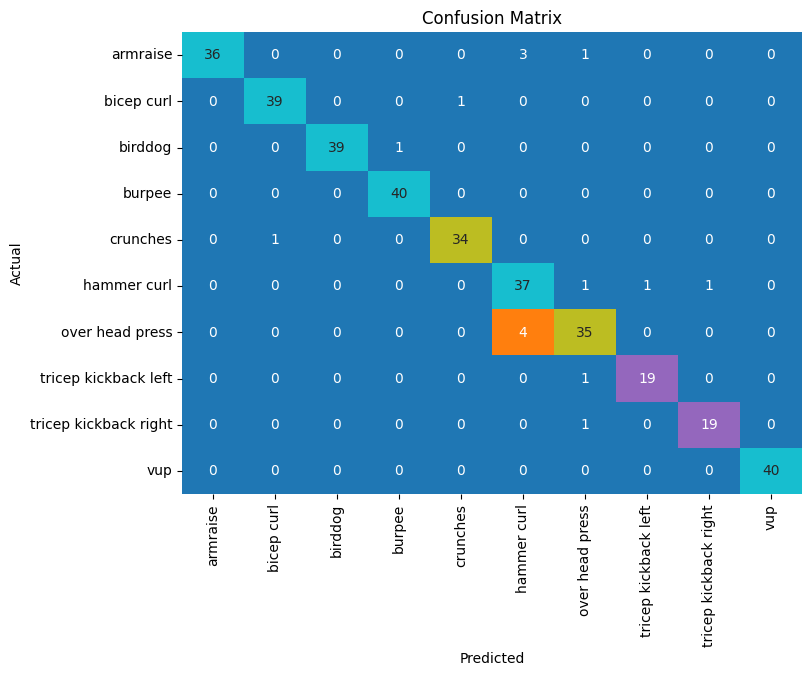

In [84]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Hyperparameter Tuning with GridSearchCV

In order to use Gridsearch with XGBoost we need to switch over to the sklearn format of XGBoost which is XGBClassifier

In [76]:
# Define the hyperparameter grid

param_grid = {
    'objective': ['multi:softmax'],
    'max_depth': [3, 4, 5, 6, 7],
    'eta': [0.2, 0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1],
}

# Train the initial XGBoost model
model_xgbc = XGBClassifier()
grid_search_xgb = GridSearchCV(model_xgbc, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search_xgb.fit(X_train_strat_s, y_train_strat_s)

print("Best set of hyperparameters: ", grid_search_xgb.best_params_)

Best set of hyperparameters:  {'eta': 0.2, 'max_depth': 5, 'objective': 'multi:softmax', 'subsample': 0.7}


In [79]:
# Setting up model with tuned parameters

best_params = grid_search_xgb.best_params_
best_xgb_model = xgb.XGBClassifier(**best_params)

best_xgb_model.fit(X_train_strat_s, y_train_strat_s)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [80]:
# prediction

y_pred = best_xgb_model.predict(X_test_strat_s)

In [81]:
# obtaining accuracy score

accuracy = accuracy_score(y_test_strat_s, y_pred)
print("Test Accuracy: ", accuracy)

Test Accuracy:  0.940677966101695


In [82]:
# Classification Report

print("\nClassification Report:\n", classification_report(y_test_strat_s, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95        40
           1       0.95      0.97      0.96        40
           2       1.00      0.97      0.99        40
           3       0.98      1.00      0.99        40
           4       0.97      0.94      0.96        35
           5       0.79      0.93      0.85        40
           6       0.86      0.82      0.84        39
           7       0.95      0.95      0.95        20
           8       0.95      0.95      0.95        20
           9       1.00      0.97      0.99        40

    accuracy                           0.94       354
   macro avg       0.94      0.94      0.94       354
weighted avg       0.94      0.94      0.94       354



In [83]:
# Confusion Matrix

conf_matrix_xgb_best = confusion_matrix(y_test_strat_s, y_pred)

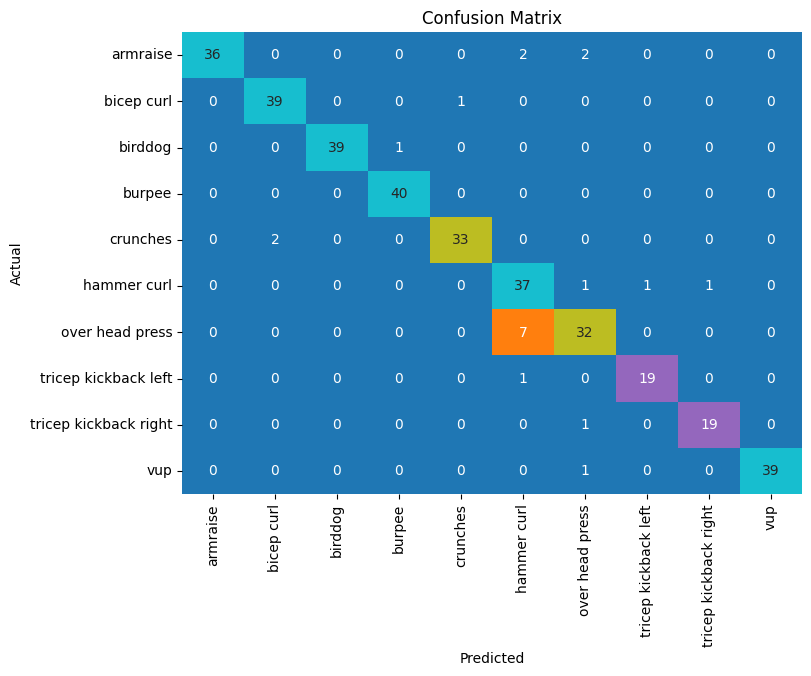

In [86]:
# Plotting the confusion matrix as a heatmap

plt.figure(figsize=(8, 6))
class_labels = ['armraise', 'bicep curl', 'birddog', 'burpee', 'crunches', 'hammer curl', 'over head press', 'tricep kickback left', 'tricep kickback right', 'vup']
sns.heatmap(conf_matrix_xgb_best, annot=True, fmt='d', cmap='tab10', cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

There is a slight decrease in accuracy after the tuning, but both attempts with the XGBoost model give more accurate predictions than any of the other models tried. 95% accuracy being the highest with the XGBoost and also computationally the fastest.

There are some other ideas that I would be interested in trying on top the work that I have already done. 
I would be interested to see how the models do with the numbers from the rotation matrices without any feature engineering,
Can the models predict the movements without the parameter data from the json files.
How many reps need to be included for the models to achieve a decent accuracy result.

I will start a new notebook to try to explore some of these ideas.